# Discord Spam Classification – Phase 1: SMS Spam Classifier using RoBERTa

## Introduction
Spam messages are a persistent problem in online communication platforms, including Discord. To build an effective Discord spam detection system, it is important to first develop a robust foundation by training a general spam classification model. This notebook covers Phase 1 of the project, where we focus on creating a spam classifier using publicly available SMS spam data.

By fine-tuning a state-of-the-art language model (RoBERTa) on SMS spam messages, we aim to teach the model general spam detection capabilities. These learned patterns will then serve as a strong base for later adapting the model specifically to Discord spam messages in Phase 2. In this notebook, we begin the first phase of building a robust spam detection system for Discord messages by first training and evaluating a spam classifier on the publicly available **SMS Spam Collection Dataset**. This phase allows us to:

- Build and evaluate a baseline spam classification model
- Experiment with **RoBERTa**, a state-of-the-art transformer model
- Gain insights into real-world performance on text spam classification
- Prepare a solid foundation for Phase 2, where we will move to Discord-specific data

## Objectives of This Phase

- Preprocess SMS messages (clean, tokenize)
- Fine-tune a pre-trained RoBERTa model on the dataset
- Evaluate model performance using precision, recall, F1-score
- Save the trained model for future comparison/use

## Dataset: SMS Spam Collection

For this notebook, we are using the **[SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)** from UCI.

### Dataset Structure
- **`v1`**: Label (`ham` or `spam`)  
- **`v2`**: The SMS message content  

We'll preprocess the dataset by:
- Renaming columns for clarity  
- Converting labels to binary:
  - `ham` → `0` (not spam)  
  - `spam` → `1` (spam)  

This binary classification will serve as Phase 1 of our larger **Discord Spam Detection** project.

## Evaluation 

> Check with precision, recall, F1-score

---

## Preparing the tools

In [88]:
# General libraries
import pandas as pd
import numpy as np
import random

# isualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Hugging Face Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Dataset
from datasets import Dataset

# PyTorch (used under the hood by transformers)
import torch
from torch import nn

import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))

# utils
from utils.preprocess import preprocess_text

## Load Data

In [57]:
df = pd.read_csv("../data/sms_spam.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [58]:
df = df[['v1', 'v2']]  # Keep only label and message
df.columns = ['label', 'text']  # Rename for consistency
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [59]:
# Convert labels to numbers
# Convert spam/ham to 1/0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [60]:
df["label"].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [62]:
df.isna().sum()

label    0
text     0
dtype: int64

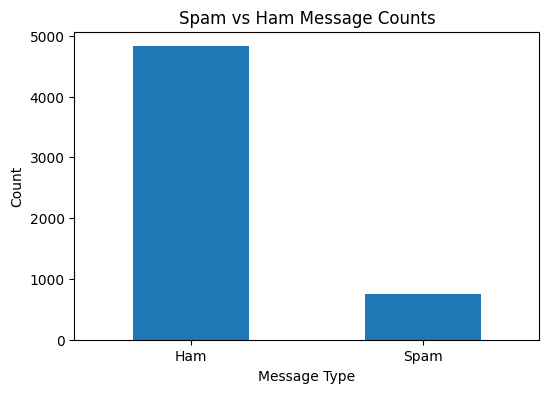

In [63]:
df["label"].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Spam vs Ham Message Counts")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

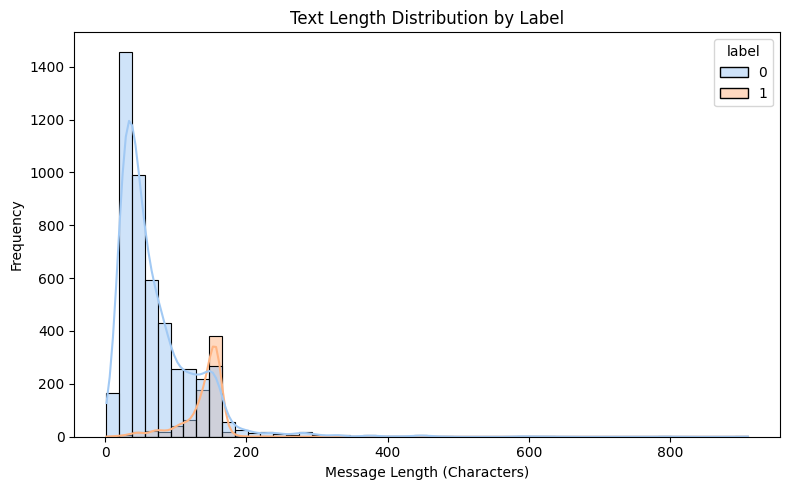

In [64]:
df["len"] = df["text"].apply(len)

# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="len", hue='label', bins=50, kde=True, palette='pastel')
plt.title("Text Length Distribution by Label")
plt.xlabel("Message Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

## Clean Data

In [65]:
df["cleaned_text"] = df["text"].apply(preprocess_text)

In [66]:
preprocess_text("Hiiii bro go www.discord.gg/invite/sdfsdf and join live on www.steam.com")

'Hiiii bro go <DISCORD_INVITE> and join live on <URL>'

In [67]:
df

,label,text,len,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",111,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...,29,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,49,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,37,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s...",57,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...,125,The guy did some bitching but I acted like i'd...


## Split Data

In [68]:
# Split data - preserve class distribution
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42,
    stratify=df['label']  # Maintain class balance in splits
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42,
    stratify=temp_df['label']
)

In [69]:
train_df.shape, val_df.shape, test_df.shape

((3900, 4), (836, 4), (836, 4))

In [70]:
train_df["label"].value_counts()

label
0    3377
1     523
Name: count, dtype: int64

In [71]:
val_df["label"].value_counts()

label
0    724
1    112
Name: count, dtype: int64

In [72]:
test_df["label"].value_counts()

label
0    724
1    112
Name: count, dtype: int64

In [73]:
train_df

,label,text,len,cleaned_text
4912,1,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",155,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ..."
2541,0,I dont. Can you send it to me. Plus how's mode.,47,I dont. Can you send it to me. Plus how's mode.
5323,0,Aah bless! How's your arm?,26,Aah bless! How's your arm?
5171,0,Oh k. . I will come tomorrow,28,Oh k. . I will come tomorrow
2532,0,Yup ok...,9,Yup ok...
...,...,...,...,...
3185,0,Happy birthday to you....dear.with lots of lov...,59,Happy birthday to you....dear.with lots of lov...
607,0,what I meant to say is cant wait to see u agai...,87,what I meant to say is cant wait to see u agai...
552,0,"Sure, if I get an acknowledgement from you tha...",120,"Sure, if I get an acknowledgement from you tha..."
763,0,Nothing but we jus tot u would ask cos u ba gu...,151,Nothing but we jus tot u would ask cos u ba gu...


We know that in this dataset, class imbalance is high. So, we need to have weighted trainer for that.

## Compute Class Weights

In [74]:
# Calculate weights based on TRAINING SET only
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

print(f"Class weights: {class_weights}")
# Example output: [0.588, 3.333] for 85/15 split

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [0.57743559 3.72848948]


## Tokenization

In [75]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

In [76]:
# Analyze optimal sequence length
token_lengths = train_df['cleaned_text'].apply(lambda x: len(tokenizer.tokenize(x)))
optimal_max_len = int(np.percentile(token_lengths, 95)) + 5  # 95th percentile + buffer

In [77]:
optimal_max_len

57

In [78]:
def tokenize_function(batch):
    try:
        return tokenizer(
            batch['text'],
            truncation=True,
            max_length=min(optimal_max_len, 512),
            padding=False,
            return_attention_mask=True,
            return_tensors=None
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

In [79]:
# 1. Select only necessary columns
train_df = train_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})
val_df = val_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})
test_df = test_df[['label', 'cleaned_text']].rename(columns={'cleaned_text': 'text'})

# 2. Convert to Dataset objects (with proper validation)
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [81]:
# 3. Apply tokenization
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']  # Remove original text after tokenization
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# 5. Sort only training set by length
tokenized_train = tokenized_train.add_column(
    "length",
    [len(x) for x in tokenized_train["input_ids"]]
).sort("length")

# Final datasets
train_dataset = tokenized_train
val_dataset = tokenized_val
test_dataset = tokenized_test

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

In [83]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 3900
})

In [84]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Pad to longest in batch
    max_length=optimal_max_len,  # Safety cap
    return_tensors="pt"
)

## Model Initialization

In [85]:
model = RobertaForSequenceClassification.from_pretrained(
    'FacebookAI/roberta-base',
    num_labels=2,
    id2label={0: "ham", 1: "spam"},
    hidden_dropout_prob=0.2,  # Regularization
    attention_probs_dropout_prob=0.2
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Custom Trainer to use a weighted loss

In [104]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(kwargs['args'].device)
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Compute metrics function

In [90]:
def compute_metrics(eval_pred):
    """Robust metrics for imbalanced binary classification"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Essential metrics (all weighted by class support)
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
    }
    
    # Class-specific metrics
    metrics.update({
        # Spam class (label=1)
        'spam_precision': precision_score(labels, predictions, pos_label=1),
        'spam_recall': recall_score(labels, predictions, pos_label=1),
        'spam_f1': f1_score(labels, predictions, pos_label=1),
        
        # Ham class (label=0)
        'ham_precision': precision_score(labels, predictions, pos_label=0),
        'ham_recall': recall_score(labels, predictions, pos_label=0),
    })
    
    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    metrics.update({
        'confusion_matrix': {
            'true_negatives': int(tn),  # Correct hams
            'false_positives': int(fp), # Hams misclassified as spam (bad)
            'false_negatives': int(fn), # Spam missed (very bad)
            'true_positives': int(tp),  # Correct spam
        },
        'false_positive_rate': fp / (fp + tn),  # % of hams flagged as spam
        'false_negative_rate': fn / (fn + tp),  # % of spam missed
    })
    
    # Full classification report (string)
    metrics['report'] = classification_report(
        labels, predictions,
        target_names=['ham', 'spam'],
        digits=4
    )
    
    return metrics

## Training Configuration

In [94]:
training_args = TrainingArguments(
    # Directory
    output_dir='./results',
    
    # Training
    num_train_epochs=5,  
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,
    
    # Optimization
    learning_rate=2e-5,
    weight_decay=0.02,
    
    # Evaluation
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    metric_for_best_model="eval_spam_recall",
    greater_is_better=True,
    load_best_model_at_end=True,
    
    # Hardware
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    
    # logging
    logging_steps=50,
    logging_dir='./logs',
    save_total_limit=2,
)

In [105]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [ ]:
# Start training (with class weights)
# trainer.train()

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print(f"Final Test Metrics: {test_results}")

# Save the best model (based on eval_spam_recall)
trainer.save_model("best_spam_classifier")
tokenizer.save_pretrained("best_spam_classifier")